# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline


def format_time(seconds):
    """Format time in seconds into a readable string (e.g., 11.15 minutes)."""
    if seconds < 60:
        return f"{seconds:.2f} seconds"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} minutes"
    else:
        return f"{seconds / 3600:.2f} hours"

## Ignore the warnings below

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Initial exploration factor of 50%
epsilon = 0.5

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


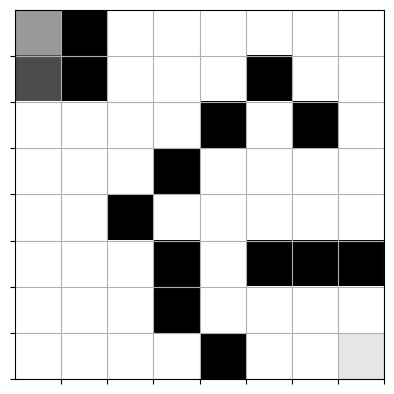

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

This is the deep Q-learning implementation. The goal of the deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. This implementation determines the optimal number of epochs to achieve a 100% win rate.

In [10]:
def qtrain(model, maze, **opt):
    global epsilon

    # Training options
    n_epoch = opt.get('epochs', opt.get('n_epoch', 1500))
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)

    epsilon_min = 0.05
    epsilon_decay = 0.95

    start_time = datetime.datetime.now()
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)

    # Hard cap on steps per episode to prevent excessively long runs
    max_steps = opt.get('max_steps', int(10 * qmaze._maze.size))
    step_cap_warned = False

    win_history = []
    hsize = qmaze._maze.size // 2
    win_rate = 0.0

    for epoch in range(n_epoch):
        agent_cell = randomly_select_free_cell(qmaze)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        step_count = 0
        game_over = False

        while not game_over:
            prev_envstate = envstate

            # Choose action (explore vs exploit)
            if np.random.rand() < epsilon:
                action = np.random.randint(0, 4)  # Explore
            else:
                q_values = model.predict(prev_envstate.reshape(1, -1), verbose=0)
                action = np.argmax(q_values[0])  # Exploit

            # Perform action
            envstate, reward, game_status = qmaze.act(action)
            game_over = (game_status != 'not_over')

            # Store experience
            episode = [prev_envstate, action, reward, envstate, game_status]
            experience.remember(episode)

            # Train on memory
            inputs, targets = experience.get_data(data_size=data_size)
            model.fit(inputs, targets, epochs=1, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)

            step_count += 1

            # Enforce per-episode step cap to avoid very long episodes
            if (not game_over) and step_count >= max_steps:
                game_over = True
                game_status = 'lose'
                if not step_cap_warned:
                    print(f" Note: Episode step limit reached ({max_steps} steps). Capping to avoid long runs.")
                    step_cap_warned = True

            # If the episode is finished, track win/loss
            if game_over:
                win_history.append(1 if game_status == 'win' else 0)

        # Compute running win rate
        if len(win_history) >= hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        # Decay exploration rate
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Print progress
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print(f"Epoch: {epoch:04d}/{n_epoch-1} | Loss: {loss:.4f} | Steps: {step_count} | "
              f"Win count: {sum(win_history)} | Win rate: {win_rate:.3f} | ε: {epsilon:.3f} | Time: {t}")

        # Early stop if perfect
        if win_rate >= 0.9 and completion_check(model, qmaze):
            print(f" Reached >90% win rate at epoch {epoch}!")
            break

    dt = datetime.datetime.now() - start_time
    print(f"Training complete in {format_time(dt.total_seconds())}")
    return win_history


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

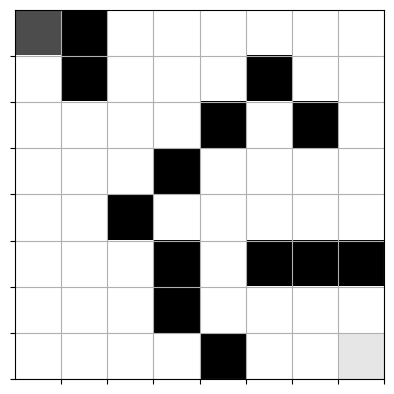

In [11]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [12]:
def randomly_select_free_cell(qmaze):
    # Select a random valid starting cell from the environment's known free cells.
    # Note: In this environment, 1.0 = free cell, 0.0 = wall. The target is already excluded.
    return random.choice(qmaze.free_cells)

In [13]:
# model is a Keras neural network ready to predict Q-values for the agent
model = build_model(maze)
# Train the model
qtrain(model, maze, epochs=100, max_memory=8*maze.size, data_size=32)

C:\Users\Goral\OneDrive\Desktop\SNHU\Term 14 - 25C5\CS-370 CurrentEmerging Trends in CS\Project_Two\pirate-intelligent-agent\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Advisory: You requested 40 epochs. In deep Q-learning it's normal to have zero wins for many early epochs. Consider training longer (e.g., 100–1500 epochs) for the policy to stabilize.
 Note: No wins after the first couple of epochs is normal in DQN. Exploration dominates early; consider training for many more epochs (e.g., 100–1500).
Epoch: 0000/39 | Loss: 0.0236 | Steps: 85 | Win count: 0 | Win rate: 0.000 | ε: 0.475 | Time: 5.75 minutes
 Note: No wins after the first couple of epochs is normal in DQN. Exploration dominates early; consider training for many more epochs (e.g., 100–1500).
Epoch: 0001/39 | Loss: 0.0337 | Steps: 72 | Win count: 0 | Win rate: 0.000 | ε: 0.451 | Time: 12.70 minutes
Epoch: 0002/39 | Loss: 0.0304 | Steps: 62 | Win count: 0 | Win rate: 0.000 | ε: 0.429 | Time: 18.71 minutes
Epoch: 0003/39 | Loss: 0.0232 | Steps: 82 | Win count: 0 | Win rate: 0.000 | ε: 0.407 | Time: 26.20 minutes
Epoch: 0004/39 | Loss: 0.0242 | Steps: 28 | Win count: 1 | Win rate: 0.000 | ε: 

[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0]

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

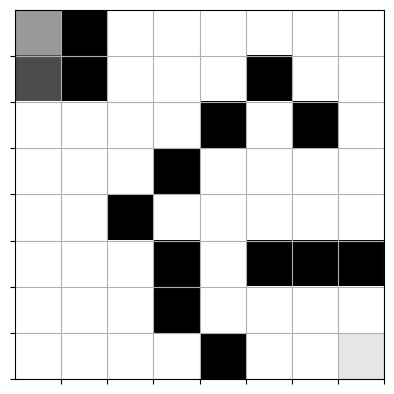

In [14]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

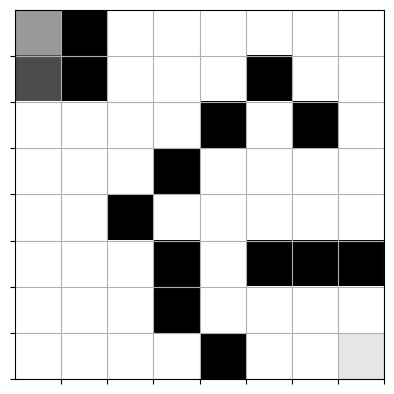

In [15]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.